# Reading the CIA World Factbook

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:

%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
# I sometimes switch between editing notebooks from my PC to my Mac;
# the code in this cell is to find the proper local data when I do so.

import platform
import os

o_s = platform.system()
paths = {}

if o_s == 'Darwin':
    paths['pickle_dir'] = '/Users/drew/data/CIA'
elif o_s == 'Windows':
    paths['pickle_dir'] = r'C:\Users\DMacKellar\Documents\Python\world_factbook'

paths['pickle_file'] = os.path.join(paths['pickle_dir'], 'text_data_CIA_factbook.pkl')

## Introduction

This notebook was inspired by [this page](https://www.kdnuggets.com/2018/03/web-scraping-python-cia-world-factbook.html), which I'm pursuing as a quick practice project in data science.  Scraping is a quick way to get data from sites that don't have an API for programmatic access; it's a common technique in data science, so I thought I'd get some practice with it.

The approach involves scraping data from the [CIA World FactBook](https://www.cia.gov/library/publications/the-world-factbook/) and looking for correlations that might explain countries' GDP.  What developmental factors are most closely associated with economic productivity?

I'm mostly using the article's author's code for connecting to the server and scraping the text data, but have expanded the scope of factors being compared, and greatly simplified the regular expressions used to get them from the [original code](https://github.com/tirthajyoti/Web-Database-Analytics-Python/blob/master/CIA-Factbook-Analytics2.ipynb).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib
import re
import ssl
from bs4 import BeautifulSoup

## Scraping 

### Connecting to the Server

The idea of importing the above packages is that you'll need urllib for handling HTTP requests, BeautifulSoup for parsing the HTML, and regex to search the text.  '`ssl`' is [secure socket layer](https://docs.python.org/3.6/library/ssl.html), and is used for handling credentials when making remote connections.

In [43]:
# Establish a connection with the server
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

# Read the HTML from the URL and pass on to BeautifulSoup
url = 'https://www.cia.gov/library/publications/the-world-factbook/'
print("Opening the file connection...")
uh = urllib.request.urlopen(url, context=ctx)
print("HTTP status", uh.getcode())
html = uh.read().decode()
print('Reading done.  Total {} characters read.'.format(len(html)))

Opening the file connection...
HTTP status 200
Reading done.  Total 75081 characters read.


Ok, so the [first command](https://docs.python.org/3.6/library/ssl.html#context-creation) is to try establishing some boilerplate args for getting the World FactBook to accept the request.  Clearly, this works to get a connection.

The url cited above is just the front page, for human-readable access, and doesn't offer specific data about the contents of the FactBook.  To check out the raw content we've stored, it's just a single text string in raw html, no splitting by carriage returns or anything:

In [11]:
# Check out some of the raw HTML of the front page

print(html[:1000])

<!DOCTYPE html>
<!--[if lt IE 7]> <html class="no-js lt-ie9 lt-ie8 lt-ie7" lang="en"> <![endif]--><!--[if IE 7]>    <html class="no-js lt-ie9 lt-ie8" lang="en"> <![endif]--><!--[if IE 8]>    <html class="no-js lt-ie9" lang="en"> <![endif]--><!--[if gt IE 8]><!--><html xmlns="http://www.w3.org/1999/xhtml" class="no-js" lang="en" xml:lang="en"><!--<![endif]--><head><meta http-equiv="Content-Type" content="text/html; charset=UTF-8" /><link rel="stylesheet" type="text/css" href="css/publications.css" /><link rel="stylesheet" type="text/css" href="css/publications-detail.css" /><meta charset="utf-8" /><meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1" /><title>The World Factbook — Central Intelligence Agency</title><meta name="description" content="" /><meta name="viewport" content="width=device-width" /><meta name="LastModified" content="Apr 01, 2016" /><link rel="stylesheet" href="css/jobcart.css" /><link rel="stylesheet" href="css/smallscreen.css" /><link rel="stylesheet" href

***

### Getting the list of Countries and Country Codes

Next, as the article notes, you pass the content to BeautifulSoup, use find_all to search it, and look for tags associated with a unique identifier for individual countries.  That's '`option`' in the case of this page.

They're all stored on line 1492 of the source code (view-source:https://www.cia.gov/library/publications/the-world-factbook/); it has 538 matches, with the context:

    <option value="geos/af.html"> Afghanistan </option><option value="geos/ax.html"> Akrotiri </option>
    
So, open and close tags; cut that number in half, remove the first tag (corresponding to "World"; apparently a repository for global info) and they're listing 268 nations.  The specific identifiers are the values of the tags between '`geos/`' and '`.html`'.  Two letter code; 26^2 is 676, so more than enough to cover all of the countries, and *most* have intuitive letters that follow somehow from their name, but 'Western Sahara' is '`geos/wi.html`', so not all are obvious.

As the article's author points out, identifying the part of the page that will contain the content you want (in this case, the location of unique country identifiers) is never automatic, since webpages aren't written in an absolutely standard way.  Peeking at the source code is helpful.

In [44]:
# Pass the front page HTML to BeautifulSoup

soup = BeautifulSoup(html, 'html.parser')
country_codes = []
country_names = []

for tag in soup.find_all('option'):
    country_codes.append(tag.get('value')[5:7])
    country_names.append(tag.text[1:-1])

temp = country_codes.pop(0) # To remove the first entry 'World'
temp = country_names.pop(0) # To remove the first entry 'World'

print('Number of country codes found by BeautifulSoup: {}'
      .format(len(country_codes)))

Number of country codes found by BeautifulSoup: 268


Ok, so here we've passed the raw HTML variable to BeautifulSoup, invoked its specific `parser` module, and used it to find all tags containing the text 'option', collected the fifth and sixth characters in its 'value' property, and appended them to the '`country_codes`' var.  We've also grabbed the human-readable country names, and appended them to '`country_names`'.  It might've been cleaner to do these as a list of dicts, so you don't risk splitting the code and names up, getting them out of order, but that's a minor niggle...

### Scraping Individual Countries' Web Pages

Once we have the country codes, we can scrape each country's page individually, and store the resulting raw HTML.  The URLs follow directly from the country codes, with the base url ending in '`/geos/`', then the country code and '`.html`'.

In [46]:
# Scrape individual country's webpages

# Base URL
urlbase = 'https://www.cia.gov/library/publications/the-world-factbook/geos/'
# Initialize an empty dict to hold the data
text_data = dict()

# Iterate over every country
for i in range(1, len(country_names) - 1):
    country_html = country_codes[i]+'.html'
    url_to_get = urlbase + country_html
    
    # Read the HTML from the URL and pass on to BeautifulSoup
    html = urllib.request.urlopen(url_to_get, context=ctx).read()
    soup = BeautifulSoup(html, 'html.parser')
    txt = soup.get_text()
    text_data[country_names[i]] = txt
    print('Finished loading data for {}'.format(country_names[i]))
    
print('\n**Finished downloading all text data!**')

Finished loading data for Afghanistan
Finished loading data for Akrotiri
Finished loading data for Albania
Finished loading data for Algeria
Finished loading data for American Samoa
Finished loading data for Andorra
Finished loading data for Angola
Finished loading data for Anguilla
Finished loading data for Antarctica
Finished loading data for Antigua and Barbuda
Finished loading data for Arctic Ocean
Finished loading data for Argentina
Finished loading data for Armenia
Finished loading data for Aruba
Finished loading data for Ashmore and Cartier Islands
Finished loading data for Atlantic Ocean
Finished loading data for Australia
Finished loading data for Austria
Finished loading data for Azerbaijan
Finished loading data for Bahamas, The
Finished loading data for Bahrain
Finished loading data for Baker Island
Finished loading data for Bangladesh
Finished loading data for Barbados
Finished loading data for Belarus
Finished loading data for Belgium
Finished loading data for Belize
Finis

Finished loading data for Southern Ocean
Finished loading data for South Georgia and South Sandwich Islands
Finished loading data for South Sudan
Finished loading data for Spain
Finished loading data for Spratly Islands
Finished loading data for Sri Lanka
Finished loading data for Sudan
Finished loading data for Suriname
Finished loading data for Svalbard
Finished loading data for Swaziland
Finished loading data for Sweden
Finished loading data for Switzerland
Finished loading data for Syria
Finished loading data for Taiwan
Finished loading data for Tajikistan
Finished loading data for Tanzania
Finished loading data for Thailand
Finished loading data for Timor-Leste
Finished loading data for Togo
Finished loading data for Tokelau
Finished loading data for Tonga
Finished loading data for Trinidad and Tobago
Finished loading data for Tunisia
Finished loading data for Turkey
Finished loading data for Turkmenistan
Finished loading data for Turks and Caicos Islands
Finished loading data for

So we're creating a dict called '`text_data`', in which every key is a country name, and every value for it is the entire HTML text parsed by BeautifulSoup.

The context arg passed to [urllib.request.urlopen](https://docs.python.org/3/library/urllib.request.html#urllib.request.urlopen) refers back to the ssl connection we established above.

The author then suggests dumping the saved data in a pickle file, so you can access later without re-downloading.

---

<font color='red'>[Side note: the article hasn't referenced it as far as I've seen, but it's always good to know about the rights/limits of programmatic access (i.e., web scraping) of sites...

I can't find this by Googling 'world factbook terms of service' or other similar variants; this **is** a heavily accessed resource, so maybe they don't mind?]</font>

---

In [47]:
# Save the output

import pickle
import os

# File path on PC
pickle_dir = r'C:\Users\DMacKellar\Documents\Python\world_factbook'
pickle_file = os.path.join(pickle_dir, 'text_data_CIA_factbook.pkl')

pickle.dump(text_data, open(pickle_file, 'wb'))

# Unpickle and read the data from local storage next time
text_data2 = pickle.load(open(pickle_file, 'rb'))

## Note: If resuming notebook, start with cell below

Regardless of the CIA's policy on scraping, once the data are pickled, there's no reason to keep pestering their server.  To get the crucial variables back, run the cell below whenever restarting this notebook, and continue from here.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import pickle
import os
import locale

# Whenever importing locale, set the locale right away
locale.setlocale(locale.LC_ALL, '')

pickle_file = paths['pickle_file']

# Unpickle and read the data from local storage
text_data = pickle.load(open(pickle_file, 'rb'))

country_names = ['World']
for country_name in sorted(text_data.keys()):
    country_names.append(country_name)

## Economic Data

### Choosing Variables to Grab

Next, we'll use regex to do the comparison the author chose: to measure any correlation between country GDP per capita and mean internet access of its citizens.  First, we look for GDP info.

---

<font color=red>[Note: I had trouble parsing the output dict, then realized that the code above keeps an extraneous whitespace character at the beginning and end of every country name.  Actually, the issue was introduced in scraping the front page to create the '`country_names`' var; the FactBook source code has spaces before and after the names to separate them from the html tags.  That's annoying, and so I'm going to change the code and repeat the scraping, then repeat the pickling.</font>

---

From looking at the "Jersey" page manually, there's a section entitled 'Economy' for each country, and it looks like the fifth subheading in that section is the value we want.  The line is formatted '`$49,500 (2015 est.)`'.  As the article mentions, we'll want to strip everything except the value 4900, and convert that to a float.

In [4]:
def convert_float(string):
    if string.isnumeric():
        return float(string)
    if string[0].isdigit():
        if ',' not in string and '.' in string:
            return float(string)
        if ',' not in string and '.' not in string:
            idx = string.find(' ')
            result = string[:idx]
            return float(result)
        idx1=string.find(',')
        idx2=string.find(' ')
        result = string[:idx1] + string[idx1+1: idx2]
        return float(result)
    else:
        return (-1)

So the function above is meant to convert human-readable digit data of the form '49,500.00' into standard Python float formatting.  Another approach [appears to be the locale module](https://stackoverflow.com/a/17815252/8637821).  I favor the dedicated module; it's a cleaner approach, quicker to implement, and useful to remember for future reference.

Here's the exact example from the text_data value for 'Egypt':

    62\nGDP - per capita (PPP):\n$13,000 (2017 est.)\n$12,800 (2016 est.)\n$12,400 (2015 est.)\nnote: data are in 2017 dollars\ncountry comparison to the world:

So, really, you should just compile a regex to return what's between the first '\n' and the first whitespace immediately following the 'GDP - per capita (PPP):' string.  So, like:

    pattern = 'GDP - per capita \(PPP\):\n(\d,.)\s\('
    gdp_per_c = pattern.search(text).group(1)

Ok, that took me a while to figure out, because pattern.match kept returning nothing.  I needed '`pattern.search`', instead.  Then I was able to cut out a couple dozen lines of the author's code.  Using regex's '`.group()`' functionality was more concise.

Also, I'm gonna expand the scope of the original author's search, too: GDP per capita is the main variable worth explaining; there may also be interesting correlations within the other economic data offered, including GDP composition by end use, and by sector of origin (i.e., is the country's economy mostly agricultural, industrial, or service-oriented?).  Finally, I'm interested in any potential association between productivity and income inequality; they offer a Gini coefficient score for countries, and I'd like to compare this to total GDP.  As a reminder, from [Wikipedia](https://en.wikipedia.org/wiki/Gini_coefficient), a Gini coefficient of zero means everyone makes/has exactly the same amount of money, and a score of one means that one person controls all the money and everyone else gets nothing.  From the scores on the FactBook, however, it looks like the CIA has rescaled them to be between 0 and 100, rather than 0 and 1.

---
### Regular Expressions Patterns

The contexts for each of these are (all from the entry for Egypt):

GDP by end use:

    GDP - composition, by end use:\nhousehold consumption: 79.2%\ngovernment consumption: 12.2%\ninvestment in fixed capital: 17.3%\ninvestment in inventories: 1.3%\nexports of goods and services: 13.5%\nimports of goods and services: -23.5% (2017 est.)\n

GDP by sector of origin:

    GDP - composition, by sector of origin:\nagriculture: 11.9%\nindustry: 33.1%\nservices: 55.7% (2017 est.)
    
Total GDP:

    GDP (purchasing power parity):\n$1.199 trillion (2017 est.)\n
    
Gini coefficient:

    Distribution of family income - Gini index:\n30.8 (2015 est.)\n32.1 (2012 est.)
    

One complication of getting total GDP is that the data are written out as trillions for Egypt, but nations' GDP could be in the billions or maybe even quadrillions?  I'm not sure; I'll write a quick search to scan through the text_data entries and see what units are given, as a preliminary step to writing the general economic parse.

In [5]:
gdp_units_pattern = re.compile(
    'GDP \(purchasing power parity\):\n\$([\d.]+) ([A-z]+)')
units = []

for i in range(1, len(country_names)-1):
    country = country_names[i]
    txt = text_data[country]
    if gdp_units_pattern.search(txt):
        print('{}: pattern found.'.format(country))
        units.append(gdp_units_pattern.search(txt).group(2))
    elif gdp_units_pattern.search(txt) == None:
        print('{}: DIDN\'T FIND SEARCH PATTERN'.format(country))
    else:
        print('Something else went wrong.')
        
units = set(units)

Afghanistan: pattern found.
Akrotiri: DIDN'T FIND SEARCH PATTERN
Albania: pattern found.
Algeria: pattern found.
American Samoa: pattern found.
Andorra: pattern found.
Angola: pattern found.
Anguilla: pattern found.
Antarctica: DIDN'T FIND SEARCH PATTERN
Antigua and Barbuda: pattern found.
Arctic Ocean: DIDN'T FIND SEARCH PATTERN
Argentina: pattern found.
Armenia: pattern found.
Aruba: pattern found.
Ashmore and Cartier Islands: DIDN'T FIND SEARCH PATTERN
Atlantic Ocean: DIDN'T FIND SEARCH PATTERN
Australia: pattern found.
Austria: pattern found.
Azerbaijan: pattern found.
Bahamas, The: pattern found.
Bahrain: pattern found.
Baker Island: DIDN'T FIND SEARCH PATTERN
Bangladesh: pattern found.
Barbados: pattern found.
Belarus: pattern found.
Belgium: pattern found.
Belize: pattern found.
Benin: pattern found.
Bermuda: pattern found.
Bhutan: pattern found.
Bolivia: pattern found.
Bosnia and Herzegovina: pattern found.
Botswana: pattern found.
Bouvet Island: DIDN'T FIND SEARCH PATTERN
Braz

In [6]:
units

{'billion', 'million', 'trillion'}

Yeah, ok, like I suspected: multiple units are used.  I'll try to code up something appropriate to capture this and convert the GDP to scientific notation.
<br/><br/>
<font color=red>[Note: One other point came up when I started the data exploration, below.  The countries are listed alphabetically once I create the dataframes, but it would be good to have a single catch-all to group them by some relevant geographical or cultural factors for comparison.  One quick candidate is under the "`Geography`" section high up on the page, the first sub-tag is "`Location`", and they're organized not just by continent, but slightly more nuanced factors: 'Western Europe', 'Caribbean', etc.  I think it would suffice to grab everything before the first comma in that section to add to the data.</font>

In [7]:
# Initialize dictionary for holding the data
region_dict = {}
gdp_per_c_dict = {}
gdp_use_dict = {}
gdp_sector_dict = {}
total_gdp_dict = {}
gini_dict = {}

gdp_per_c_pattern = re.compile(
    'GDP - per capita \(PPP\):\n\$([\d,.]+)')

gdp_use_pattern = re.compile(
    'GDP - composition, by end use:\n\
household consumption: (?P<household>[\d.]+)%\n\
government consumption: (?P<government>[\d.]+)%\n\
investment in fixed capital: (?P<fixed_capital>[\d.]+)%\n\
investment in inventories: (?P<inventories>[\d.]+)%\n\
exports of goods and services: (?P<export>[\d.]+)%\n\
imports of goods and services: (?P<import>[\d.-]+)')

gdp_sector_pattern = re.compile(
    'GDP - composition, by sector of origin:\n\
agriculture: (?P<agriculture>[\d.]+)%\n\
industry: (?P<industry>[\d.]+)%\n\
services: (?P<services>[\d.]+)%')

total_gdp_pattern = re.compile(
    'GDP \(purchasing power parity\):\n\$([\d.]+) ([A-z]+)')

gini_pattern = re.compile(
    'Distribution of family income - Gini index:\n([\d.]+)')

# Iterate over every country
# output whether the pattern worked
# and save output if it is
for i in range(1, len(country_names)-1):
    country = country_names[i]
    txt = text_data[country]
    region_pattern = re.compile(str(country).upper()
                                + ' \nLocation:\n([A-z ]+),')

    print('{}: '.format(country))
    # Get region
    if region_pattern.search(txt):
        region = region_pattern.search(txt).group(1)
        print('Region: {}'.format(region))
        region_dict[country] = region
    else:
        print('**Didn\'t find region search string**')
    # Get GDP per capita
    if gdp_per_c_pattern.search(txt):
        gdp_per_c = locale.atof(gdp_per_c_pattern.search(txt).group(1))
        print('GDP per capita: {}'.format(gdp_per_c))
        gdp_per_c_dict[country] = float(gdp_per_c)
    else:
        print('**Didn\'t find GDP per capita string**')
    # Get GDP by usage
    if gdp_use_pattern.search(txt):
        country_use_dict = gdp_use_pattern.search(txt).groupdict()
        country_use_dict.update((k, float(v)) 
                                for k, v in country_use_dict.items())
        print('GDP composition by end use: {}'.format(country_use_dict))
        gdp_use_dict[country] = country_use_dict
    else:
        print('**Didn\'t find GDP by end use string**')
    # Get GDP by sector generating
    if gdp_sector_pattern.search(txt):
        country_sector_dict = gdp_sector_pattern.search(txt).groupdict()
        country_sector_dict.update((k, float(v))
                                  for k, v in country_sector_dict.items())
        print('GDP composition by sector of origin: {}'
              .format(country_sector_dict))
        gdp_sector_dict[country] = country_sector_dict
    else:
        print('**Didn\'t find GDP by sector string**')
    # Get total GDP
    if total_gdp_pattern.search(txt):
        raw_score = float(total_gdp_pattern.search(txt).group(1))
        conversions = {'million': 1E6, 'billion': 1E9, 'trillion': 1E12}
        country_total_gdp = raw_score * conversions[
            total_gdp_pattern.search(txt).group(2)]
        print('Total GDP: {}'.format(country_total_gdp))
        total_gdp_dict[country] = float(country_total_gdp)
    else:
        print('**Didn\'t find total GDP search pattern**')
    # Get Gini coefficient
    if gini_pattern.search(txt):
        country_gini = float(gini_pattern.search(txt).group(1))
        print('Gini coefficient: {}\n'.format(country_gini))
        gini_dict[country] = country_gini
    else:
        print('**Didn\'t find Gini coefficient search pattern**\n')

Afghanistan: 
Region: Southern Asia
GDP per capita: 1900.0
GDP composition by end use: {'household': 108.6, 'government': 12.8, 'fixed_capital': 18.2, 'inventories': 0.0, 'export': 6.6, 'import': -46.2}
GDP composition by sector of origin: {'agriculture': 22.0, 'industry': 22.0, 'services': 56.0}
Total GDP: 69510000000.0
**Didn't find Gini coefficient search pattern**

Akrotiri: 
Region: Eastern Mediterranean
**Didn't find GDP per capita string**
**Didn't find GDP by end use string**
**Didn't find GDP by sector string**
**Didn't find total GDP search pattern**
**Didn't find Gini coefficient search pattern**

Albania: 
Region: Southeastern Europe
GDP per capita: 12500.0
GDP composition by end use: {'household': 77.6, 'government': 10.9, 'fixed_capital': 27.0, 'inventories': 0.0, 'export': 29.7, 'import': -45.2}
GDP composition by sector of origin: {'agriculture': 22.6, 'industry': 23.8, 'services': 53.7}
Total GDP: 35870000000.0
Gini coefficient: 29.0

Algeria: 
Region: Northern Africa


GDP composition by sector of origin: {'agriculture': 3.9, 'industry': 31.6, 'services': 64.0}
Total GDP: 2406000000000.0
Gini coefficient: 48.2

Micronesia, Federated States of: 
Region: Oceania
GDP per capita: 3400.0
**Didn't find GDP by end use string**
GDP composition by sector of origin: {'agriculture': 26.3, 'industry': 18.9, 'services': 54.8}
Total GDP: 347000000.0
Gini coefficient: 61.1

Midway Islands: 
**Didn't find region search string**
**Didn't find GDP per capita string**
**Didn't find GDP by end use string**
**Didn't find GDP by sector string**
**Didn't find total GDP search pattern**
**Didn't find Gini coefficient search pattern**

Moldova: 
Region: Eastern Europe
GDP per capita: 5700.0
GDP composition by end use: {'household': 90.0, 'government': 19.1, 'fixed_capital': 23.0, 'inventories': 0.1, 'export': 51.0, 'import': -83.1}
GDP composition by sector of origin: {'agriculture': 14.2, 'industry': 21.0, 'services': 64.8}
Total GDP: 20070000000.0
Gini coefficient: 26.8

M

GDP composition by sector of origin: {'agriculture': 0.0, 'industry': 26.0, 'services': 74.0}
Total GDP: 513700000000.00006
Gini coefficient: 45.8

Sint Maarten: 
Region: Caribbean
GDP per capita: 66800.0
**Didn't find GDP by end use string**
GDP composition by sector of origin: {'agriculture': 0.4, 'industry': 18.3, 'services': 81.3}
Total GDP: 365800000.0
**Didn't find Gini coefficient search pattern**

Slovakia: 
Region: Central Europe
GDP per capita: 32900.0
GDP composition by end use: {'household': 55.2, 'government': 19.2, 'fixed_capital': 20.9, 'inventories': 1.2, 'export': 96.4, 'import': -93.0}
GDP composition by sector of origin: {'agriculture': 3.8, 'industry': 35.0, 'services': 61.2}
Total GDP: 178700000000.0
Gini coefficient: 23.7

Slovenia: 
Region: south Central Europe
GDP per capita: 34100.0
GDP composition by end use: {'household': 52.0, 'government': 18.8, 'fixed_capital': 18.9, 'inventories': 1.1, 'export': 82.3, 'import': -73.2}
GDP composition by sector of origin: 

Ok, so there are a lot of countries without Gini data; mostly smaller ones, it seems.  Further, some countries have economic data, but no suitable region: apparently because some contain strange characters, such as Turkey:

    Southeastern Europe and Southwestern Asia (that portion of Turkey west of the Bosporus is geographically part of Europe)
    
---

### Loading into DataFrames

Now, I'll just want to load the resulting dicts into a pandas dataframe.  Once I get them in, I'll handle the NaN values appropriately.

In [8]:
# Let's define individual dataframes for each data type
region_s = pd.Series(region_dict, name='Region')
gdp_sector_df = pd.DataFrame(gdp_sector_dict).T
gdp_sector_df.columns = pd.MultiIndex.from_product(
    [['GDP_from_sector'], gdp_sector_df.columns])

gdp_use_df = pd.DataFrame(gdp_use_dict).T
gdp_use_df.columns = pd.MultiIndex.from_product(
    [['GDP_by_use'], gdp_use_df.columns])

loose_dicts = [gdp_per_c_dict, total_gdp_dict, gini_dict, region_dict]
loose_df = pd.DataFrame(loose_dicts, index=[
    'GDP_per_cap', 'Total_GDP', 'Gini', 'Region']).T
loose_df.columns = pd.MultiIndex.from_product(
    [['Other_measures'], loose_df.columns])

# Now merge them sequentially, keeping n/a values,
# So I have all together in one df
gdps_df = pd.merge(gdp_sector_df, gdp_use_df, 
                   left_index=True, right_index=True, how='outer')
econ_df = pd.merge(loose_df, gdps_df,
                   left_index=True, right_index=True, how='outer')
econ_df.head()

Other_measures                                          \
                  GDP_per_cap  Total_GDP  Gini                 Region   
Afghanistan              1900  6.951e+10   NaN          Southern Asia   
Akrotiri                  NaN        NaN   NaN  Eastern Mediterranean   
Albania                 12500  3.587e+10    29    Southeastern Europe   
Algeria                 15100  6.293e+11  35.3        Northern Africa   
American Samoa          13000   7.11e+08   NaN                Oceania   

               GDP_from_sector                   GDP_by_use                \
                   agriculture industry services     export fixed_capital   
Afghanistan               22.0     22.0     56.0        6.6          18.2   
Akrotiri                   NaN      NaN      NaN        NaN           NaN   
Albania                   22.6     23.8     53.7       29.7          27.0   
Algeria                   13.2     36.1     50.7       21.0          42.7   
American Samoa            27.4     12.4     60.2        NaN           NaN   

                                                        
               government household import inventories  
Afghanistan          12.8     108.6  -46.2         0.0  
Akrotiri              NaN       NaN    NaN         NaN  
Albania              10.9      77.6  -45.2         0.0  
Algeria              21.4      42.7  -35.5         7.6  
American Samoa        NaN       NaN    NaN         NaN

Hmm... some countries have nothing but a region; no economic data.  I don't think I'll want anything that doesn't at least have per capita GDP, so I'll drop them.

In [9]:
print('Shape before: {}'.format(econ_df.shape))

# It took me WAY too long to figure out how to dropna
# On multi-indexed df; the approach below works
econ_df = econ_df[econ_df['Other_measures', 'GDP_per_cap'].notnull()]
print('Shape after: {}'.format(econ_df.shape))
econ_df.head()

Shape before: (253, 13)
Shape after: (227, 13)


Other_measures                                        \
                  GDP_per_cap  Total_GDP  Gini               Region   
Afghanistan              1900  6.951e+10   NaN        Southern Asia   
Albania                 12500  3.587e+10    29  Southeastern Europe   
Algeria                 15100  6.293e+11  35.3      Northern Africa   
American Samoa          13000   7.11e+08   NaN              Oceania   
Andorra                 49900  3.327e+09   NaN  Southwestern Europe   

               GDP_from_sector                   GDP_by_use                \
                   agriculture industry services     export fixed_capital   
Afghanistan               22.0     22.0     56.0        6.6          18.2   
Albania                   22.6     23.8     53.7       29.7          27.0   
Algeria                   13.2     36.1     50.7       21.0          42.7   
American Samoa            27.4     12.4     60.2        NaN           NaN   
Andorra                   11.9     33.6     54.5        NaN           NaN   

                                                        
               government household import inventories  
Afghanistan          12.8     108.6  -46.2         0.0  
Albania              10.9      77.6  -45.2         0.0  
Algeria              21.4      42.7  -35.5         7.6  
American Samoa        NaN       NaN    NaN         NaN  
Andorra               NaN       NaN    NaN         NaN

### Tagging Countries with Regions

Now, to summarize the number of countries we've got:

In [10]:
print('Number of regions: {}'.format(
    econ_df['Other_measures', 'Region'].unique().shape))
print('Countries per region: \n{}'.format(econ_df[
    'Other_measures', 'Region'].value_counts(dropna=False)))

Number of regions: (39,)
Countries per region: 
Oceania                                          23
Caribbean                                        22
Middle East                                      15
Western Africa                                   15
Southern Africa                                  11
Southeastern Asia                                11
Central Africa                                   10
Western Europe                                    9
Central Europe                                    8
Southeastern Europe                               8
Southern Asia                                     8
Eastern Asia                                      7
Central America                                   7
Eastern Europe                                    6
Northern Europe                                   6
Northern Africa                                   6
NaN                                               6
Central Asia                                      5
Eastern Africa  

Now, for the missing regions.

In [11]:
econ_df[econ_df['Other_measures', 'Region'].isnull()]

Other_measures                          \
                                     GDP_per_cap  Total_GDP  Gini Region   
Falkland Islands (Islas Malvinas)          96200  2.818e+08    36    NaN   
France                                     43600  2.826e+12  29.2    NaN   
South Sudan                                 1500  1.975e+10    46    NaN   
Sudan                                       4600  1.868e+11   NaN    NaN   
Turkey                                     26500  2.133e+12  40.2    NaN   
Uganda                                      2400  8.861e+10  39.5    NaN   

                                  GDP_from_sector                    \
                                      agriculture industry services   
Falkland Islands (Islas Malvinas)             NaN      NaN      NaN   
France                                        1.6     19.4     78.9   
South Sudan                                   NaN      NaN      NaN   
Sudan                                        39.6      2.6     57.8   
Turkey                                        6.7     31.8     61.4   
Uganda                                       24.5     23.2     52.3   

                                  GDP_by_use                           \
                                      export fixed_capital government   
Falkland Islands (Islas Malvinas)        NaN           NaN        NaN   
France                                  30.3          22.0       23.5   
South Sudan                              NaN           NaN        NaN   
Sudan                                    8.9          18.5        6.1   
Turkey                                   NaN           NaN        NaN   
Uganda                                  18.8          23.9       10.0   

                                                                
                                  household import inventories  
Falkland Islands (Islas Malvinas)       NaN    NaN         NaN  
France                                 54.8  -32.0         1.3  
South Sudan                             NaN    NaN         NaN  
Sudan                                  77.3  -11.7         0.9  
Turkey                                  NaN    NaN         NaN  
Uganda                                 71.7  -24.7         0.3

I currently lack the pandas expertise to parse those in a way that makes sense.  I'll just replace them with 'Miscellaneous'.

In [12]:
econ_df['Other_measures', 'Region'].fillna('Misc', inplace=True)
econ_df[econ_df['Other_measures', 'Region'].isnull()]

Empty DataFrame
Columns: [(Other_measures, GDP_per_cap), (Other_measures, Total_GDP), (Other_measures, Gini), (Other_measures, Region), (GDP_from_sector, agriculture), (GDP_from_sector, industry), (GDP_from_sector, services), (GDP_by_use, export), (GDP_by_use, fixed_capital), (GDP_by_use, government), (GDP_by_use, household), (GDP_by_use, import), (GDP_by_use, inventories)]
Index: []

Furthermore, there are too many regions to be very useful.  I'll consolidate.

In [13]:
econ_df['Other_measures', 'G_region'] = econ_df['Other_measures', 'Region']
fix_regions = {re.compile('.*Africa'): 'Africa', 
               re.compile('.*South America'): 'South America',
               re.compile('.*North America'): 'North America',
               re.compile('.*Europe'): 'Europe',
               re.compile('.*Asia'): 'Asia',
               re.compile('.* Ocean'): 'Misc Islands'
              }
econ_df['Other_measures', 'G_region'].replace(
    to_replace=fix_regions, inplace=True)

In [14]:
econ_df.head()

Other_measures                                        \
                  GDP_per_cap  Total_GDP  Gini               Region   
Afghanistan              1900  6.951e+10   NaN        Southern Asia   
Albania                 12500  3.587e+10    29  Southeastern Europe   
Algeria                 15100  6.293e+11  35.3      Northern Africa   
American Samoa          13000   7.11e+08   NaN              Oceania   
Andorra                 49900  3.327e+09   NaN  Southwestern Europe   

               GDP_from_sector                   GDP_by_use                \
                   agriculture industry services     export fixed_capital   
Afghanistan               22.0     22.0     56.0        6.6          18.2   
Albania                   22.6     23.8     53.7       29.7          27.0   
Algeria                   13.2     36.1     50.7       21.0          42.7   
American Samoa            27.4     12.4     60.2        NaN           NaN   
Andorra                   11.9     33.6     54.5        NaN           NaN   

                                                       Other_measures  
               government household import inventories       G_region  
Afghanistan          12.8     108.6  -46.2         0.0           Asia  
Albania              10.9      77.6  -45.2         0.0         Europe  
Algeria              21.4      42.7  -35.5         7.6         Africa  
American Samoa        NaN       NaN    NaN         NaN        Oceania  
Andorra               NaN       NaN    NaN         NaN         Europe

In [15]:
econ_df['Other_measures', 'G_region'].value_counts(dropna=False)

Africa             49
Europe             47
Asia               35
Oceania            23
Caribbean          22
Middle East        15
South America      12
Central America     7
North America       6
Misc                6
Misc Islands        5
Name: (Other_measures, G_region), dtype: int64

Ok, that keeps the Middle East separate from the rest of Asia (and from North Africa), and Central America as distinct from the rest of North America, but those are outcomes I can live with.  I mean, France is still left out of Europe until I adopt a more nuanced approach.  Let's just see what they look like.

First, just for fun, let's see the 25 top countries for per capita GDP:

In [16]:
econ_df.sort_values([('Other_measures', 'GDP_per_cap')], ascending=False).iloc[:25,0]

Liechtenstein                        139100
Qatar                                124900
Monaco                               115700
Macau                                114400
Luxembourg                           109100
Falkland Islands (Islas Malvinas)     96200
Singapore                             90500
Bermuda                               85700
Isle of Man                           84600
Brunei                                76700
Ireland                               72600
Norway                                70600
Kuwait                                69700
United Arab Emirates                  68200
Sint Maarten                          66800
Gibraltar                             61700
Switzerland                           61400
Hong Kong                             61000
United States                         59500
San Marino                            59500
Saudi Arabia                          55300
Netherlands                           53600
Guernsey                        

## Exploring Economic Data

Ok, let's visualize some of the summarized data regarding economic variables.

Now that I've gotten the economic data associated with world regions, let's get a global view; literally, by checking out per capita GDP by continent.

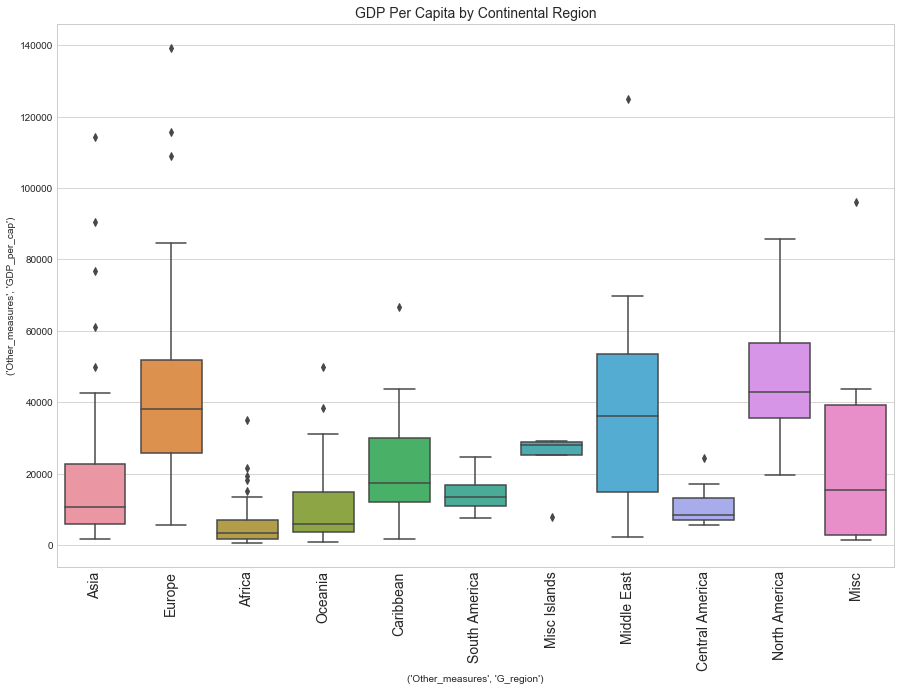

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
hfont = {'fontsize': '14'}

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.clear()

x = econ_df['Other_measures', 'G_region'].astype(str)
y = econ_df['Other_measures', 'GDP_per_cap'].astype(float)
ax = sns.boxplot(x=x, y=y)
plt.xticks(rotation='vertical', **hfont)
plt.title('GDP Per Capita by Continental Region', **hfont)
plt.show()

Ok, so North America has the highest mean GDP per capita (USA! USA!).  Let's try just lumping all nations together and seeing how their various measures are distributed for the whole data set.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


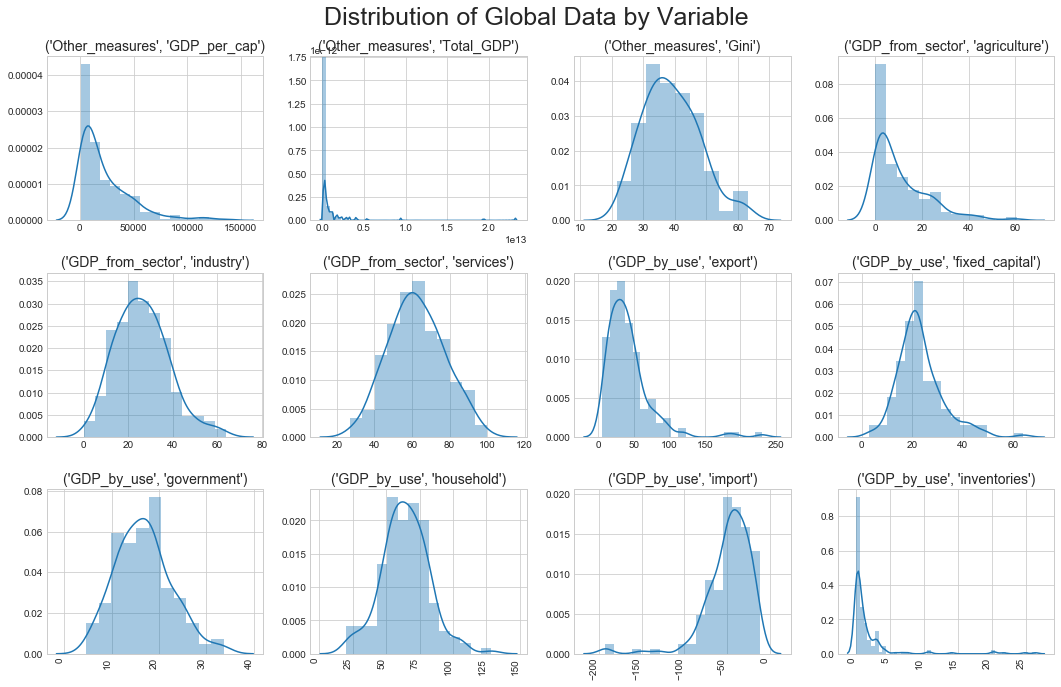

In [18]:
sns.set_style('whitegrid')
hfont = {'fontsize': '14'}
figkw = {'figsize': (15, 10)}

fig, axs = plt.subplots(3, 4, **figkw)
plt.suptitle('Distribution of Global Data by Variable', 
             fontsize=25, verticalalignment='top')
fig.autofmt_xdate(rotation=90)
ax.clear()

data_cols = [x for x in econ_df.columns if \
             'Region' not in x and 'G_region' not in x]

for name, ax in zip(data_cols, axs.flatten()):
    y = econ_df[name].dropna().astype(float)
    sns.distplot(a=y, ax=ax)
    ax.set_title(name, fontsize=14)
    ax.xaxis.label.set_visible(False)
    for tk in ax.get_xticklabels():
            tk.set_visible(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Total GDP is by far the most unevenly distributed variable.  

In [19]:
print(econ_df['Other_measures', 'Total_GDP'].max())
with pd.option_context('display.max_rows', 10, 'display.max_columns', 2):
    print(econ_df['Other_measures', 'Total_GDP'].sort_values())

23120000000000.0
Tokelau                                            1.5e+06
Niue                                             1.001e+07
Saint Helena, Ascension, and Tristan da Cunha     3.11e+07
Tuvalu                                             4.2e+07
Montserrat                                       4.378e+07
                                                   ...    
Germany                                           4.15e+12
Japan                                            5.405e+12
India                                            9.447e+12
United States                                    1.936e+13
China                                            2.312e+13
Name: (Other_measures, Total_GDP), Length: 227, dtype: object


The US and China both make around $20 Trillion, but many small island nations tens or hundreds of millions, a difference of 5 or 6 orders of magnitude.  I wonder how total economic strength compares to average productivity per citizen.

In [21]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool, LabelSet, ColumnDataSource

output_notebook()

source = ColumnDataSource(data=econ_df)

p1 = figure(title="(Log) Per Capita GDP vs. (Log) Total GDP", 
            tools="hover", x_axis_type='log', 
            y_axis_type='log', x_axis_label='Total GDP in USD', 
            y_axis_label='Per capita GDP in USD', plot_width=800)

p1.title.align = 'center'
p1.title.text_font_size = "20px"

# labels = LabelSet(x='Other_measures_Total_GDP', 
#                   y='Other_measures_GDP_per_cap', 
#                   text='index', level='glyph', x_offset=5, y_offset=5,
#                   source=source)

p1.circle(x='Other_measures_Total_GDP',
          y='Other_measures_GDP_per_cap',
          name='index',
          source=source,
          size=15)

hover = p1.select(dict(type=HoverTool))
hover.tooltips = '@index'
show(p1)

Loading BokehJS ...

Ok, cool.  To get the above, I had to embark on a crash course in using Bokeh (D3.js-like library in Python).  I left in a block to add the labels as static parts of the plot, but it's too crowded to keep them in.  The best use is as a hover-tab, which works when I run the code in my notebook in an active kernel (but might not if you're viewing a frozen page).  Long story short: you set many options when calling the figure, but plot the data with a separate call to the "renderer" (i.e., the "`p1.circle`" call on line 22).  To feed in data, you pass a dict or dataframe to the "`ColumnDataSource`" method.  If you have multiindexed columns/indices in your df, this latter method will automatically join the hierarchical labels with underscores, and rename the df's index to a column just generically called '`index`'.

Next, I wonder how GDP per capita compares based on occupancy of the sector of the economy?

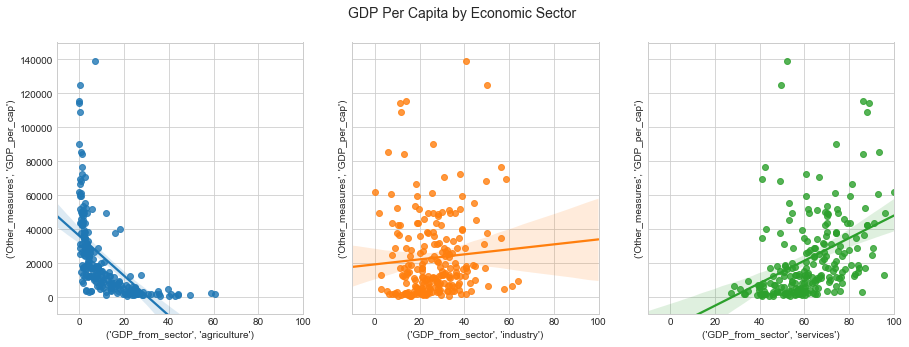

In [22]:
figkw = {'figsize': (15, 5)}

x1 = econ_df['GDP_from_sector', 'agriculture'].astype(float)
x2 = econ_df['GDP_from_sector', 'industry'].astype(float)
x3 = econ_df['GDP_from_sector', 'services'].astype(float)
y = econ_df['Other_measures', 'GDP_per_cap'].astype(float)

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, **figkw)
ax.clear()
plt.xlim([-10, 100])
plt.ylim([-10000, 150000])
plt.suptitle('GDP Per Capita by Economic Sector', **hfont)

sns.regplot(x=x1, y=y, ax=axs[0])
sns.regplot(x=x2, y=y, ax=axs[1])
sns.regplot(x=x3, y=y, ax=axs[2])
plt.show()

Ok, that's a pretty clear demonstration that a service economy tends to pay much better than an agrarian one.  

I expect it to be less significant, but let's try plotting against the "use" categories, too:

In [23]:
econ_df.head()

Other_measures                                        \
                  GDP_per_cap  Total_GDP  Gini               Region   
Afghanistan              1900  6.951e+10   NaN        Southern Asia   
Albania                 12500  3.587e+10    29  Southeastern Europe   
Algeria                 15100  6.293e+11  35.3      Northern Africa   
American Samoa          13000   7.11e+08   NaN              Oceania   
Andorra                 49900  3.327e+09   NaN  Southwestern Europe   

               GDP_from_sector                   GDP_by_use                \
                   agriculture industry services     export fixed_capital   
Afghanistan               22.0     22.0     56.0        6.6          18.2   
Albania                   22.6     23.8     53.7       29.7          27.0   
Algeria                   13.2     36.1     50.7       21.0          42.7   
American Samoa            27.4     12.4     60.2        NaN           NaN   
Andorra                   11.9     33.6     54.5        NaN           NaN   

                                                       Other_measures  
               government household import inventories       G_region  
Afghanistan          12.8     108.6  -46.2         0.0           Asia  
Albania              10.9      77.6  -45.2         0.0         Europe  
Algeria              21.4      42.7  -35.5         7.6         Africa  
American Samoa        NaN       NaN    NaN         NaN        Oceania  
Andorra               NaN       NaN    NaN         NaN         Europe

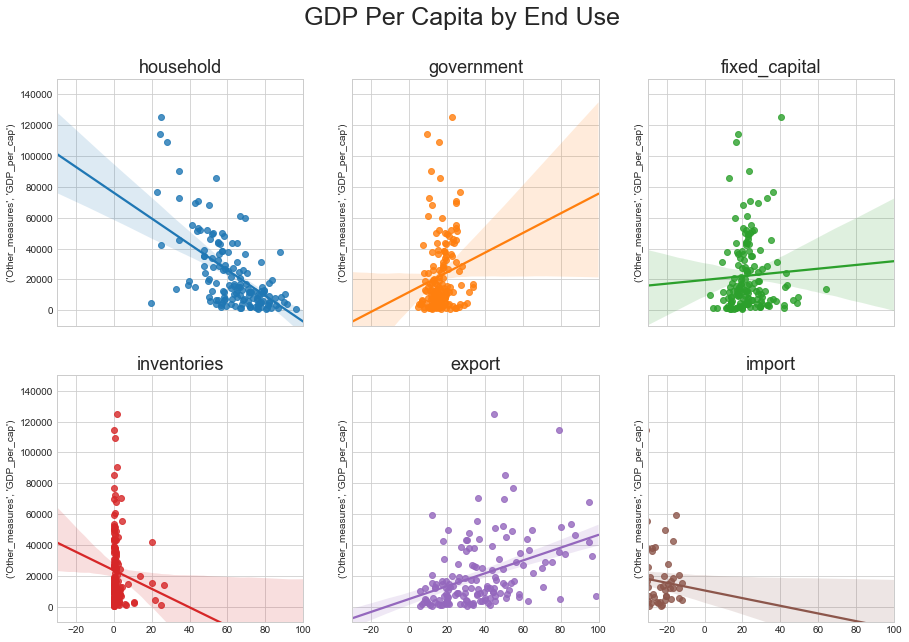

In [24]:
figkw = {'figsize': (15, 10)}
hfont = {'fontsize': '14'}

uses = ['household', 'government', 'fixed_capital', 
        'inventories', 'export', 'import']

y = econ_df['Other_measures', 'GDP_per_cap'].astype(float)

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, **figkw)
plt.suptitle('GDP Per Capita by End Use', fontsize=25)
ax.clear()
plt.xlim([-30, 100])
plt.ylim([-10000, 150000])

for x, ax in zip(uses, axs.flatten()):
    sns.regplot(x=econ_df['GDP_by_use', x].astype(float), y=y, ax=ax)
    ax.set_title(x, fontsize=18)
    ax.xaxis.label.set_visible(False)
plt.show()

Hmm, still some interesting trends.  To interpret what's going on, it helps to check the [FactBook's breakdown](https://www.cia.gov/library/publications/the-world-factbook/docs/notesanddefs.html?fieldkey=2259&term=GDP%20-%20composition,%20by%20end%20use) of these categories.  The salutary effect of exports on GDP is very predictable, as are the deleterious effects of imports and 'household' (i.e., general consumer spending).  The most interesting thing, however, is the large positive (although highly variable) effect of government spending: is this some form of latent argument for socialism?

How about the pet hypothesis I mentioned earlier: that there could be a negative correlation between total GDP and Gini?  I'll have to use a semi-log plot, since the total GDP has so much range that I need to plot it in log.

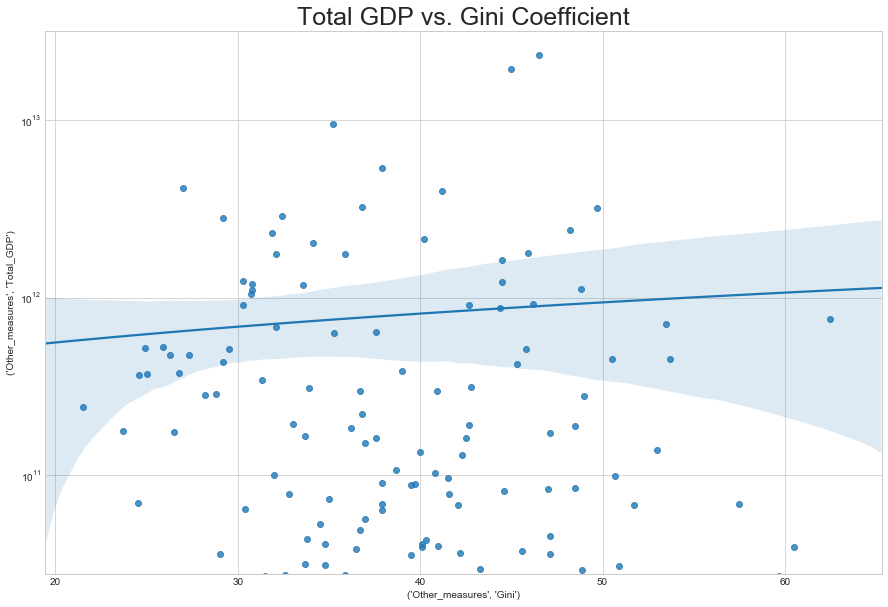

In [25]:
x = econ_df['Other_measures', 'Gini'].astype(float)
y = econ_df['Other_measures', 'Total_GDP'].astype(float)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.clear()
plt.title('Total GDP vs. Gini Coefficient', fontsize=25)

ax = sns.regplot(x=x, y=y)
plt.yscale('log')
plt.show()

Hmm... Ok; not much there.  If anything, there's a weak positive correlation (meaning that total GDP may increase with greater inequality), but it probably isn't all that significant.  I may test that later with a real regression model.

## Demographic and Other Data

### Choosing Variables, Defining Patterns

Ok, I can do more exploration of the economic data later, perhaps.

To what other factors do we want to compare the economic data?  The FactBook contains considerable demographic data; we might want to know what other outcomes/behaviors are associated with productivity.  The context there is (again, from Egypt, lines 5507-5514):

    <div id='field' class='category afr_light' style='padding-left:5px;'><a href='../docs/notesanddefs.html?fieldkey=2010&term=Age structure'>Age structure:</a><a href='../fields/2010.html#eg'><img style='float: right;padding: 4px; border: 0; text-decoration:none;' src='../graphics/field_listing_on.gif'></a></div>
    <div><span class=category>0-14 years: </span><span class=category_data>33.29% (male 16,720,307/female 15,583,019)</span></div>
    <div><span class=category>15-24 years: </span><span class=category_data>18.94% (male 9,464,262/female 8,919,614)</span></div>
    <div><span class=category>25-54 years: </span><span class=category_data>37.6% (male 18,545,422/female 17,944,582)</span></div>
    <div><span class=category>55-64 years: </span><span class=category_data>5.95% (male 2,861,136/female 2,911,586)</span></div>
    <div><span class=category>65 years and over: </span><span class=category_data>4.22% (male 1,993,248/female 2,097,896) (2017 est.)</span></div>
    <div class='disTable popPyramid'><span class='category tCell' style='margin-bottom:0px; vertical-align:bottom;'>population pyramid:</span>
    
Now, the original article's author's code for this is again a more convoluted approach than I'd take.  Basically, I need to match the part after '`Age structure: `', but unfortunately the crucial '`0-14 years: `' category labels are matched twice in the raw HTML, once after '`Age structure:`', and another after '`Sex ratio:`'.  I should figure out the way to use BeautifulSoup to parse the raw HTML such that it recognizes the hierarchy of HTML code to exclude the match that follows the sex ratios.

Actually, never mind: at least in the pickled '`text_data`' content, the tags are absent, so BeautifulSoup will be less useful here unless I repeat the scraping.  So the context *isn't* what's printed above, but is:

    Age structure:\n0-14 years: 33.29% (male 16,720,307/female 15,583,019)\n15-24 years: 18.94% (male 9,464,262/female 8,919,614)\n25-54 years: 37.6% (male 18,545,422/female 17,944,582)\n55-64 years: 5.95% (male 2,861,136/female 2,911,586)\n65 years and over: 4.22% (male 1,993,248/female 2,097,896) (2017 est.)\n

Instead, I'll try just setting up a very particular regex pattern so that I only grab the demographic data directly after the '`Age structure:`' text.  I found a pattern that works; it's a little long and literal, but I'm not gonna overthink it.  

Another demographic figure worth considering; it might be a more direct measure of what's important to productivity.  The FactBook contains "Dependency ratios", which are numbers of people relative to every 100 others that are working.  The context for that is:

    Dependency ratios:\ntotal dependency ratio: 61.8\nyouth dependency ratio: 53.6\nelderly dependency ratio: 8.2\npotential support ratio: 12.2 (
    
Urbanization would also seem to be an important indicator:

    Urbanization:\nurban population: 43.3% of total population 
    
And another one is frequently used a summary of overall health:

    Infant mortality rate:\ntotal: 19 deaths/1,000 live births\n
    
Oh, and: definitely want:

    nLiteracy:\ndefinition: age 15 and over can read and write\ntotal population: 73.8%\n
    
---

Finally, there are only a couple other data points I can think of that might stand a good chance of having a high correlation with GDP in this data set.  If you want productivity, you not only need literate, healthy people, but also to provide them with access to information and energy.  The author of the article that inspired this notebook chose internet access as a crucial measure of informatic integration, and I'll follow that same factor.  But access to electricity is also pretty important, so I'll grab those data, too.

Contexts in `text_data`:

    Internet users:\ntotal: 37,122,537\npercent of population: 39.2% (July 2016 est.)\ncountry
    
    electrification - total population: 99.6%\n

I'll store in dicts first, then pass to a dataframe.

In [26]:
# Initialize regex patterns, dicts, and lists of each
age_structure_pattern = re.compile('Age structure:\n\
0-14 years: ([\d.]+)% \(male [\d,]+/female [\d,]+\)\n\
15-24 years: ([\d.]+)% \(male [\d,]+/female [\d,]+\)\n\
25-54 years: ([\d.]+)% \(male [\d,]+/female [\d,]+\)\n\
55-64 years: ([\d.]+)% \(male [\d,]+/female [\d,]+\)\n\
65 years and over: ([\d.]+)% \(male [\d,]+/female [\d,]+\)')

dependency_pattern = re.compile('Dependency ratios:\ntotal \
dependency ratio: ([\d.]+)\nyouth')

urbanization_pattern = re.compile('Urbanization:\nurban \
population: ([\d.]+)% of total population')

infant_m_pattern = re.compile('Infant mortality rate:\ntotal: \
([\d.]+) deaths/1,000 live births\n')

literacy_pattern = re.compile('Literacy:\ndefinition: \
age 15 and over can read and write\ntotal population: ([\d.]+)%\n')

internet_pattern = re.compile('Internet users:\ntotal: [\d,.]+\n\
percent of population: ([\d.]+)% \(')

electric_pattern = re.compile('electrification - \
total population: ([\d.]+)%\n')

patterns = [age_structure_pattern, dependency_pattern, 
            urbanization_pattern, infant_m_pattern, 
            literacy_pattern, internet_pattern, electric_pattern]

(age_structure_dict, dependency_dict, urbanization_dict, infant_dict, 
 literacy_dict, internet_dict, electric_dict) = {},{},{},{},{},{},{}

dicts = [age_structure_dict, dependency_dict, urbanization_dict,
        infant_dict, literacy_dict, internet_dict, electric_dict]

ages = ['0-14', '14-24', '25-54', '55-64', '65+']

# Iterate over every country
# output whether the pattern worked
# and save output if it is
for i in range(1, len(country_names)-1):
    country = country_names[i]
    txt = text_data[country]
    print('{}: '.format(country))
    
    for pattern, dictS in zip(patterns, dicts):
        # Make a special case of the age distributions,
        # since it alone contains multiple groups
        if pattern == age_structure_pattern:
            if age_structure_pattern.search(txt):
                country_ages = {}
                print('Ages as % of population: ')
                for i, age in enumerate(ages):
                    age_match = pattern.search(txt).group(i+1)
                    country_ages[age] = age_match
                    print('{}: {}%'.format(age, age_match))
                age_structure_dict[country] = country_ages
            else:
                print('**Age breakdown pattern not found**')

        # For the remaining patterns, handle all the same
        elif pattern != age_structure_pattern:
            if pattern.search(txt):
                pattern_match = pattern.search(txt).group(1)
                print('Pattern {}: {}'.format(
                    pattern, pattern_match))
                dictS[country] = float(pattern_match)
            else:
                print('**{} pattern not found**'.format(pattern))
        else:
                print('Something went really wrong in this cell.')

Afghanistan: 
Ages as % of population: 
0-14: 40.92%
14-24: 22.22%
25-54: 30.35%
55-64: 3.92%
65+: 2.59%
Pattern re.compile('Dependency ratios:\ntotal dependency ratio: ([\\d.]+)\nyouth'): 88.8
Pattern re.compile('Urbanization:\nurban population: ([\\d.]+)% of total population'): 27.6
Pattern re.compile('Infant mortality rate:\ntotal: ([\\d.]+) deaths/1,000 live births\n'): 110.6
Pattern re.compile('Literacy:\ndefinition: age 15 and over can read and write\ntotal population: ([\\d.]+)%\n'): 38.2
Pattern re.compile('Internet users:\ntotal: [\\d,.]+\npercent of population: ([\\d.]+)% \\('): 10.6
Pattern re.compile('electrification - total population: ([\\d.]+)%\n'): 43
Akrotiri: 
**Age breakdown pattern not found**
**re.compile('Dependency ratios:\ntotal dependency ratio: ([\\d.]+)\nyouth') pattern not found**
**re.compile('Urbanization:\nurban population: ([\\d.]+)% of total population') pattern not found**
**re.compile('Infant mortality rate:\ntotal: ([\\d.]+) deaths/1,000 live births\

Pattern re.compile('Infant mortality rate:\ntotal: ([\\d.]+) deaths/1,000 live births\n'): 4.6
Pattern re.compile('Literacy:\ndefinition: age 15 and over can read and write\ntotal population: ([\\d.]+)%\n'): 97.7
Pattern re.compile('Internet users:\ntotal: [\\d,.]+\npercent of population: ([\\d.]+)% \\('): 69.1
**re.compile('electrification - total population: ([\\d.]+)%\n') pattern not found**
Greenland: 
Ages as % of population: 
0-14: 21.11%
14-24: 15.48%
25-54: 41.21%
55-64: 12.96%
65+: 9.24%
**re.compile('Dependency ratios:\ntotal dependency ratio: ([\\d.]+)\nyouth') pattern not found**
Pattern re.compile('Urbanization:\nurban population: ([\\d.]+)% of total population'): 87.2
Pattern re.compile('Infant mortality rate:\ntotal: ([\\d.]+) deaths/1,000 live births\n'): 8.9
Pattern re.compile('Literacy:\ndefinition: age 15 and over can read and write\ntotal population: ([\\d.]+)%\n'): 100
Pattern re.compile('Internet users:\ntotal: [\\d,.]+\npercent of population: ([\\d.]+)% \\('): 68

65+: 3.13%
Pattern re.compile('Dependency ratios:\ntotal dependency ratio: ([\\d.]+)\nyouth'): 88.2
Pattern re.compile('Urbanization:\nurban population: ([\\d.]+)% of total population'): 49.4
Pattern re.compile('Infant mortality rate:\ntotal: ([\\d.]+) deaths/1,000 live births\n'): 69.8
Pattern re.compile('Literacy:\ndefinition: age 15 and over can read and write\ntotal population: ([\\d.]+)%\n'): 59.6
Pattern re.compile('Internet users:\ntotal: [\\d,.]+\npercent of population: ([\\d.]+)% \\('): 25.7
Pattern re.compile('electrification - total population: ([\\d.]+)%\n'): 45
Niue: 
**Age breakdown pattern not found**
**re.compile('Dependency ratios:\ntotal dependency ratio: ([\\d.]+)\nyouth') pattern not found**
Pattern re.compile('Urbanization:\nurban population: ([\\d.]+)% of total population'): 44
**re.compile('Infant mortality rate:\ntotal: ([\\d.]+) deaths/1,000 live births\n') pattern not found**
**re.compile('Literacy:\ndefinition: age 15 and over can read and write\ntotal popula

Pattern re.compile('electrification - total population: ([\\d.]+)%\n'): 27
Venezuela: 
Ages as % of population: 
0-14: 27.36%
14-24: 17.03%
25-54: 40.53%
55-64: 7.98%
65+: 7.09%
Pattern re.compile('Dependency ratios:\ntotal dependency ratio: ([\\d.]+)\nyouth'): 52.6
Pattern re.compile('Urbanization:\nurban population: ([\\d.]+)% of total population'): 89.1
Pattern re.compile('Infant mortality rate:\ntotal: ([\\d.]+) deaths/1,000 live births\n'): 12.2
Pattern re.compile('Literacy:\ndefinition: age 15 and over can read and write\ntotal population: ([\\d.]+)%\n'): 97.1
Pattern re.compile('Internet users:\ntotal: [\\d,.]+\npercent of population: ([\\d.]+)% \\('): 60.0
Pattern re.compile('electrification - total population: ([\\d.]+)%\n'): 99.7
Vietnam: 
Ages as % of population: 
0-14: 23.55%
14-24: 16.23%
25-54: 45.56%
55-64: 8.55%
65+: 6.12%
Pattern re.compile('Dependency ratios:\ntotal dependency ratio: ([\\d.]+)\nyouth'): 42.5
Pattern re.compile('Urbanization:\nurban population: ([\\d.]

In [27]:
# Find out how many countries were captured by each pattern
for i, dictS in enumerate(dicts):
    print('{}: {} keys'.format(i, len(dictS.keys())))

0: 228 keys
1: 197 keys
2: 228 keys
3: 223 keys
4: 150 keys
5: 215 keys
6: 137 keys


Ok, so there are plenty of entries without dependency ratios or urbanization data; furthermore many countries' pages lacked info about access to electricity.  There will be a lot of missing data in those categories.

Now, to transfer to pandas.

In [28]:
# Let's define individual dataframes for each data type

ages_df = pd.DataFrame(age_structure_dict).T
ages_df.columns = pd.MultiIndex.from_product(
    [['Age_structure'], ages_df.columns])

col_names = ['dependency_ratio', 'urbanization', 
             'infant_mort', 'literacy', 'internet', 
             'electricity']
loose_df2 = pd.DataFrame(dicts[1:], index=col_names).T
loose_df2.columns = pd.MultiIndex.from_product(
    [['Other_factors'], loose_df2.columns])

# Now merge them sequentially, keeping n/a values,
# So I have all together in one df
demo_df = pd.merge(ages_df, loose_df2, 
                   left_index=True, right_index=True, how='outer')
demo_df.head()

Age_structure                                Other_factors  \
                        0-14  14-24  25-54  55-64    65+ dependency_ratio   
Afghanistan            40.92  22.22  30.35   3.92   2.59             88.8   
Albania                18.05  17.47  41.06  11.54  11.89             44.0   
Algeria                29.31   15.3  42.93   6.81   5.65             52.7   
American Samoa         30.28  18.79  36.38   8.58   5.97              NaN   
Andorra                 14.4   9.64  46.18  14.16  15.61              NaN   

                                                                       
               urbanization infant_mort literacy internet electricity  
Afghanistan            27.6       110.6     38.2     10.6        43.0  
Albania                59.3        11.9     97.6     66.4         NaN  
Algeria                71.9        19.6     80.2     42.9        99.0  
American Samoa         87.1        11.3      NaN     31.3        59.0  
Andorra                84.1         3.6    100.0     97.9         NaN

In [29]:
print(econ_df.shape, demo_df.shape)

(227, 14) (235, 11)


To explore this dataframe as-is, I'd have to repeat the region-coding process; I think it's easier to just join this to the existing `econ_df`, and do some visualization from there.

In [30]:
cia_data = econ_df.join(demo_df)
print(cia_data.shape)
# print(cia_data.columns)
cia_data.head()

(227, 25)


Other_measures                                        \
                  GDP_per_cap  Total_GDP  Gini               Region   
Afghanistan              1900  6.951e+10   NaN        Southern Asia   
Albania                 12500  3.587e+10    29  Southeastern Europe   
Algeria                 15100  6.293e+11  35.3      Northern Africa   
American Samoa          13000   7.11e+08   NaN              Oceania   
Andorra                 49900  3.327e+09   NaN  Southwestern Europe   

               GDP_from_sector                   GDP_by_use                \
                   agriculture industry services     export fixed_capital   
Afghanistan               22.0     22.0     56.0        6.6          18.2   
Albania                   22.6     23.8     53.7       29.7          27.0   
Algeria                   13.2     36.1     50.7       21.0          42.7   
American Samoa            27.4     12.4     60.2        NaN           NaN   
Andorra                   11.9     33.6     54.5        NaN           NaN   

                              ...     Age_structure                       \
               government     ...             14-24  25-54  55-64    65+   
Afghanistan          12.8     ...             22.22  30.35   3.92   2.59   
Albania              10.9     ...             17.47  41.06  11.54  11.89   
Algeria              21.4     ...              15.3  42.93   6.81   5.65   
American Samoa        NaN     ...             18.79  36.38   8.58   5.97   
Andorra               NaN     ...              9.64  46.18  14.16  15.61   

                  Other_factors                                             \
               dependency_ratio urbanization infant_mort literacy internet   
Afghanistan                88.8         27.6       110.6     38.2     10.6   
Albania                    44.0         59.3        11.9     97.6     66.4   
Algeria                    52.7         71.9        19.6     80.2     42.9   
American Samoa              NaN         87.1        11.3      NaN     31.3   
Andorra                     NaN         84.1         3.6    100.0     97.9   

                            
               electricity  
Afghanistan           43.0  
Albania                NaN  
Algeria               99.0  
American Samoa        59.0  
Andorra                NaN  

[5 rows x 25 columns]

### Exploring Demographic and Other Data

Ok, now to get some plots of how the age, health, energy and informatic/educational data break down.  Let's look at how the new "Other_factors" compare across regions.

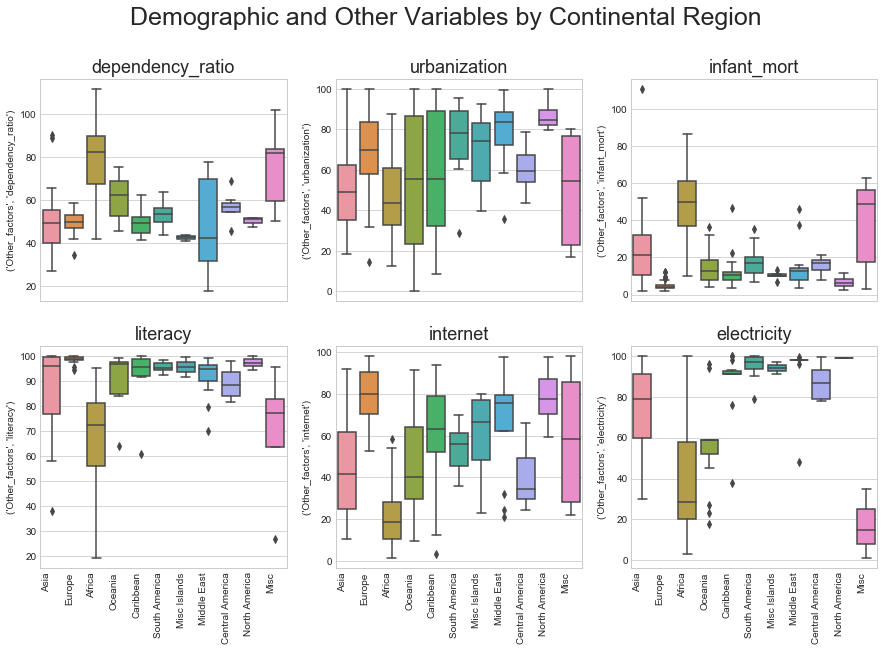

In [31]:
sns.set_style('whitegrid')
hfont = {'fontsize': '14'}
figkw = {'figsize': (15, 10)}

fig, axs = plt.subplots(2, 3, sharex=True, **figkw)
plt.suptitle('Demographic and Other Variables by Continental Region', 
             fontsize=25)
fig.autofmt_xdate(rotation=90)
ax.clear()

x = cia_data['Other_measures', 'G_region']

for name, ax in zip(col_names, axs.flatten()):
    y = cia_data['Other_factors', name].astype(float)
    sns.boxplot(x=x, y=y, ax=ax)
    ax.set_title(name, fontsize=18)
    ax.xaxis.label.set_visible(False)

plt.show()

It's a lot to take in, but in general the trend is clear that Europe is in the best position for most of these measures, and Africa the worst (at least, where we can state there's an "ideal" measure for some thing: infant mortality is bad, but is urbanization inherently good?).

Now, let's see some scatterplots against GDP_per_capita.

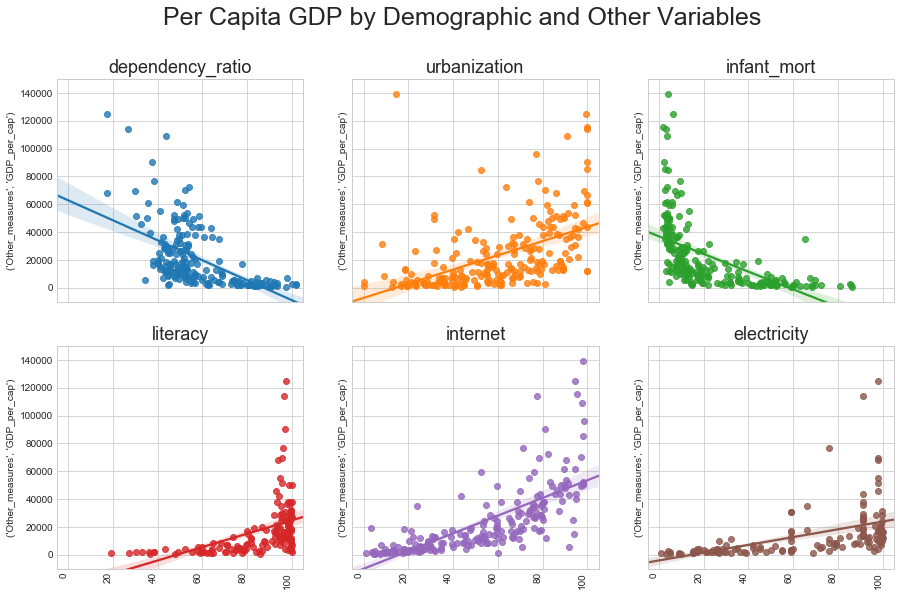

In [32]:
# Set global options
sns.set_style('whitegrid')
hfont = {'fontsize': '14'}
figkw = {'figsize': (15, 10)}

# Set up the figure
fig, axs = plt.subplots(2, 3, sharex=True, 
                        sharey=True, **figkw)
plt.suptitle('Per Capita GDP by Demographic and Other Variables',
            fontsize=25)
fig.autofmt_xdate(rotation=90)
plt.xlim([-5, 105])
plt.ylim([-10000, 150000])
ax.clear()

y = cia_data['Other_measures', 'GDP_per_cap']

# Plot individual subplots
for name, ax in zip(col_names, axs.flatten()):
    x = cia_data['Other_factors', name].astype(float)
    sns.regplot(x=x, y=y, ax=ax)
    ax.set_title(name, fontsize=18)
    ax.xaxis.label.set_visible(False)
plt.show()

Ok; those are informative (and pretty intuitive).  Infant mortality has a negative correlation with GDP per person; the rest have pretty obvious positive correlations.  Can I get more fine-grained, as in with actual modeling or statistical testing?  If I get time, I'll try these out below.

For the nonce, I'll make an exhaustive correlation matrix, an all-vs-all comparison.  It took me **way** too long to figure this out, but I couldn't get the pd.DataFrame.corr() method to output for the longest time, until I came across a comment online that says that the data type for many columns can be "object", even if visual inspection of the data demonstrates that they're strictly numerical.  So: first drop the columns with strings, then call '`df.astype(float).corr()`'.

In [33]:
cia_num = cia_data.drop(level=1, columns=['Region', 'G_region'])
cia_corr = cia_num.astype(float).corr()
cia_corr

Other_measures                      \
                                    GDP_per_cap Total_GDP      Gini   
Other_measures  GDP_per_cap            1.000000  0.085624 -0.338294   
                Total_GDP              0.085624  1.000000  0.043479   
                Gini                  -0.338294  0.043479  1.000000   
GDP_from_sector agriculture           -0.557344 -0.103929  0.148940   
                industry               0.071630  0.083547  0.012978   
                services               0.395531  0.008556 -0.144520   
GDP_by_use      export                 0.562693 -0.132065 -0.118835   
                fixed_capital          0.046113  0.090172 -0.010871   
                government             0.156699 -0.030800 -0.239541   
                household             -0.619977 -0.130631  0.129107   
                import                -0.290822  0.216371  0.104008   
                inventories           -0.109530 -0.036001  0.031500   
Age_structure   0-14                  -0.613929 -0.149780  0.413822   
                14-24                 -0.607691 -0.151618  0.526904   
                25-54                  0.479303  0.115161 -0.227946   
                55-64                  0.528631  0.129240 -0.495603   
                65+                    0.553657  0.138707 -0.521180   
Other_factors   dependency_ratio      -0.572707 -0.144354  0.223621   
                urbanization           0.509616  0.093693 -0.188667   
                infant_mort           -0.545412 -0.103419  0.352394   
                literacy               0.447152  0.082902 -0.121568   
                internet               0.721953  0.099680 -0.450674   
                electricity            0.465050  0.170347  0.035593   

                                 GDP_from_sector                      \
                                     agriculture  industry  services   
Other_measures  GDP_per_cap            -0.557344  0.071630  0.395531   
                Total_GDP              -0.103929  0.083547  0.008556   
                Gini                    0.148940  0.012978 -0.144520   
GDP_from_sector agriculture             1.000000 -0.232151 -0.608464   
                industry               -0.232151  1.000000 -0.618683   
                services               -0.608464 -0.618683  1.000000   
GDP_by_use      export                 -0.366124  0.068176  0.248584   
                fixed_capital          -0.061745  0.176619 -0.117854   
                government             -0.329375  0.072800  0.222821   
                household               0.525223 -0.335937 -0.171622   
                import                  0.161293  0.066626 -0.174935   
                inventories             0.117433 -0.017489 -0.091413   
Age_structure   0-14                    0.684727 -0.014960 -0.542033   
                14-24                   0.576545 -0.022148 -0.462373   
                25-54                  -0.576455  0.199623  0.302234   
                55-64                  -0.574771 -0.100236  0.553226   
                65+                    -0.518864 -0.097228  0.505359   
Other_factors   dependency_ratio        0.665664 -0.208224 -0.406278   
                urbanization           -0.565121  0.019908  0.441246   
                infant_mort             0.725410 -0.001624 -0.576865   
                literacy               -0.690339  0.219974  0.425445   
                internet               -0.687877  0.072600  0.511324   
                electricity            -0.701120  0.246665  0.403296   

                                 GDP_by_use                           \
                                     export fixed_capital government   
Other_measures  GDP_per_cap        0.562693      0.046113   0.156699   
                Total_GDP         -0.132065      0.090172  -0.030800   
                Gini              -0.118835     -0.010871  -0.239541   
GDP_from_sector agriculture       -0.366124     -0.061745  -0.329375   
                industry

Or, for a graphical output ([from a user comment](https://stackoverflow.com/a/42323184/8637821) on stack overflow):

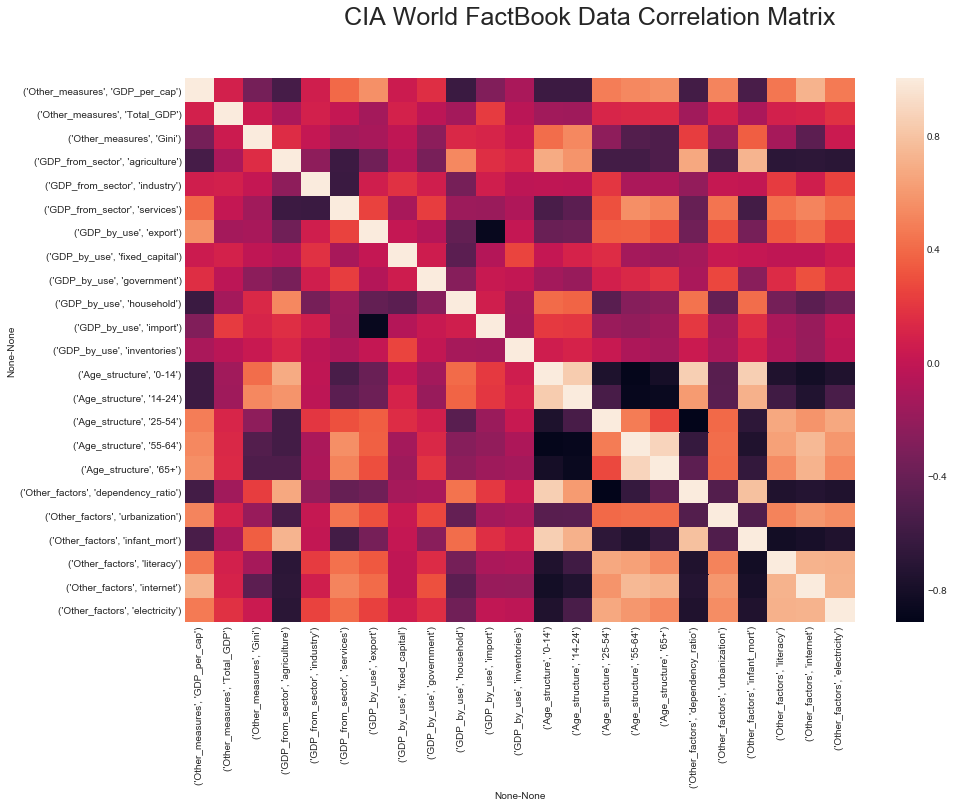

In [34]:
hfont = {'fontsize': '14'}
figkw = {'figsize': (15, 10)}

fig, axs = plt.subplots(1, 1, **figkw)
plt.suptitle('CIA World FactBook Data Correlation Matrix',
            fontsize=25)
# fig.autofmt_xdate(rotation=90)

sns.heatmap(cia_corr, 
        xticklabels=cia_corr.columns,
        yticklabels=cia_corr.columns)
plt.show()

And, at the risk of beating this horse to death, here are the correlations sorted by strength with per capita GDP.

In [35]:
cia_corr.sort_values([('Other_measures', 'GDP_per_cap')], ascending=False).iloc[:,0]

Other_measures   GDP_per_cap         1.000000
Other_factors    internet            0.721953
GDP_by_use       export              0.562693
Age_structure    65+                 0.553657
                 55-64               0.528631
Other_factors    urbanization        0.509616
Age_structure    25-54               0.479303
Other_factors    electricity         0.465050
                 literacy            0.447152
GDP_from_sector  services            0.395531
GDP_by_use       government          0.156699
Other_measures   Total_GDP           0.085624
GDP_from_sector  industry            0.071630
GDP_by_use       fixed_capital       0.046113
                 inventories        -0.109530
                 import             -0.290822
Other_measures   Gini               -0.338294
Other_factors    infant_mort        -0.545412
GDP_from_sector  agriculture        -0.557344
Other_factors    dependency_ratio   -0.572707
Age_structure    14-24              -0.607691
                 0-14             

### Brief Analysis

Reach of internet access is indeed an important factor, apparently; so are export, then working-age people, and urbanization.  The most negatively correlated factors are having many young people and dependents, as well as consumer/household spending, an agrarian society, and infant mortality.

Of course, these are all correlative: suggestive but ambiguous.  Probably internet access interacts with GDP in a feedback loop: richer countries will have better access, but being well-networked will aid its citizens to further boost productivity.  By contrast, impoverished countries have poorer access, overall, but if two similarly impoverished countries were to have vastly different access, I would predict that greater access would give a country a boost (which may be measured in, say, GDP growth, a value I didn't pick up in this notebook).  Most of these factors probably interact with GDP in complicated ways: a relatively mature economy is a factor both driving and in turn promoted by urbanization.

One curious possible exception is the strong correlation of GDP with people that are 55+; these sectors are even more strongly associated than are typically working-age people in the prime of their lives (25-54 year-olds).  I could be wrong, but I would expect that these categories are mostly indicators, rather than drivers; the causal loop points *from* GDP and *towards* the elderly.  It takes a robust economy to ensure good health and survival of people late into life, but these people aren't in turn driving most of the economic productivity.

Naturally, all of these things could be teased out better by more slicing and dicing of the data, but at this point I think I've delved deeply enough to fulfill the purpose of this notebook, which was of course primarily to practice acquiring and sorting the data.

Additionally, I'd love to be able to build a predictive model for GDP per capita, but the very small size of this data set (especially after handling missing data) has kept me from having any luck.  I'll skip this for now.